# 1. AirPassengers Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ïù¥Ïö©Ìïú ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°

###  library load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(9,6)
import warnings
warnings.filterwarnings("ignore")

import pmdarima as pm
from inspect import signature
from tbats import TBATS, BATS
from arch import arch_model
from arch.data import sp500

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

###  AirPassengers Î°úÎìú & Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨ 

In [2]:
ap = pd.read_csv("./data/AirPassengers.csv", parse_dates=["Month"], index_col="Month")
ap = ap.asfreq("MS")  
y = ap["#Passengers"].astype(float)

display(y)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

### Î°úÍ∑∏ Î≥ÄÌôò(Î∂ÑÏÇ∞ ÏïàÏ†ïÌôî)
- Ï∂îÏÑ∏‚Üë + Í≥ÑÏ†àÏÑ±(12Í∞úÏõî) + Î≥ÄÎèôÏÑ± Ï¶ùÍ∞Ä(Î∂ÑÏÇ∞ ÎπÑÏ†ïÏÉÅ)

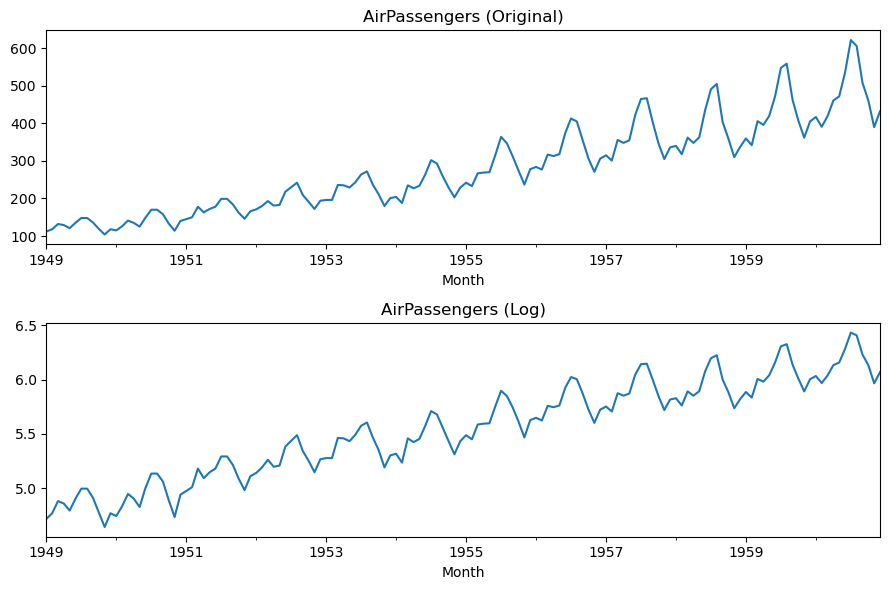

In [3]:
y_log = np.log(y)

fig, ax = plt.subplots(2, 1)
y.plot(ax=ax[0], title="AirPassengers (Original)")
y_log.plot(ax=ax[1], title="AirPassengers (Log)")
plt.tight_layout()
plt.show()

###  STL Î∂ÑÌï¥
- Trend: ÏôÑÎßåÌïú Ï¶ùÍ∞Ä
- Seasonal: 12Í∞úÏõî Ï£ºÍ∏∞ Î∞òÎ≥µ
- Residual: Ìå®ÌÑ¥ ÏóÜÏùå ‚Üí Î™®Îç∏ÎßÅ Ï§ÄÎπÑ OK

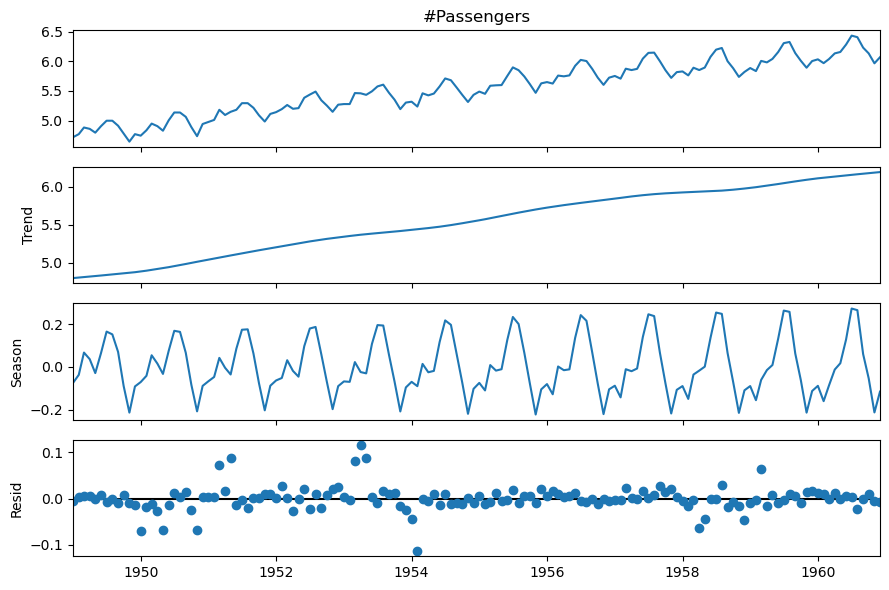

In [4]:
stl = STL(y_log, period=12, robust=True)
res = stl.fit()
res.plot()
plt.show()

### Ï†ïÏÉÅÏÑ± Í≤ÄÏÇ¨ (ADF/KPSS)
- Î°úÍ∑∏Îßå Ï∑®Ìïú ÏãúÍ≥ÑÏó¥ÏùÄ Ï∂îÏÑ∏/Í≥ÑÏ†àÏÑ± ÎïåÎ¨∏Ïóê ÎπÑÏ†ïÏÉÅ
- 1Ï∞® Ï∞®Î∂Ñ(d=1) + 12Í≥ÑÏ†à Ï∞®Î∂Ñ(D=1) ÌõÑÏóêÎäî ADF¬∑KPSSÍ∞Ä Î™®Îëê Ï†ïÏÉÅÏÑ±ÏùÑ ÏßÄÏßÄ

In [5]:
def adf_print(x, name="series"):
    stat, p, *_ = adfuller(x.dropna())
    print(f"ADF[{name}] p-value:", p)

def kpss_print(x, name="series"):
    stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")
    print(f"KPSS[{name}] p-value:", p)

adf_print(y_log, "log(y)")
kpss_print(y_log, "log(y)")

ADF[log(y)] p-value: 0.42236677477038814
KPSS[log(y)] p-value: 0.01


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_10984\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### Ï∞®Î∂Ñ ÌõÑ Ï†ïÏÉÅÏÑ± Í≤ÄÏÇ¨
- ADF[log(y) 1Ï∞® + Í≥ÑÏ†à(12) Ï∞®Î∂Ñ] p = 0.00025 (< 0.05)
  - Îã®ÏúÑÍ∑º ÏóÜÏùå ‚Üí Ï†ïÏÉÅÏÑ± Îã¨ÏÑ±
- KPSS[log(y) 1Ï∞® + Í≥ÑÏ†à(12) Ï∞®Î∂Ñ] p = 0.1 (‚â• 0.1Î°ú Ï∫°Îê®)
  - Ï†ïÏÉÅÏÑ± Í∑ÄÎ¨¥Î•º Í∏∞Í∞ÅÌïòÏßÄ Î™ªÌï® ‚Üí Ï†ïÏÉÅÏÑ±Ïóê Î¨∏Ï†ú ÏóÜÏùåÏúºÎ°ú Ìï¥ÏÑù

In [6]:
dy  = y_log.diff().dropna()      
Ddy = dy.diff(12).dropna()          

adf_print(Ddy, "log(y) diff1 & seas12")
kpss_print(Ddy, "log(y) diff1 & seas12")

ADF[log(y) diff1 & seas12] p-value: 0.00024859123113839645
KPSS[log(y) diff1 & seas12] p-value: 0.1


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_10984\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### ACF/PACF
- ACF 12Î∞∞ÏàòÏóêÏÑú Ïú†Ïùò ‚Üí Í≥ÑÏ†à MA(Q) ÌõÑÎ≥¥
- PACF 12Î∞∞ÏàòÏóêÏÑú Ïú†Ïùò ‚Üí Í≥ÑÏ†à AR(P) ÌõÑÎ≥¥   
‚Üí ÏûëÏùÄ Í∑∏Î¶¨ÎìúÎ°ú SARIMA ÌÉêÏÉâ ÌïÑÏöî

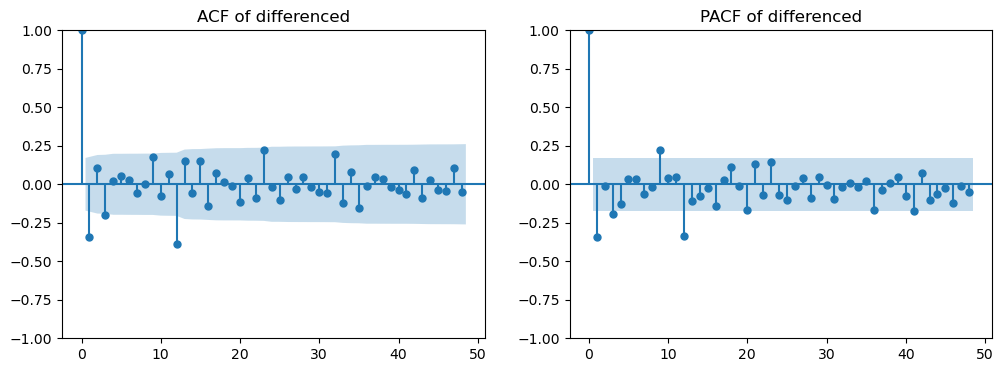

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

plot_acf(Ddy, lags=48, ax=ax[0])
ax[0].set_title("ACF of differenced")
plot_pacf(Ddy, lags=48, ax=ax[1])
ax[1].set_title("PACF of differenced")
plt.show()

### ARIMA ÌïôÏäµ & ÏòàÏ∏°

#### Train/Test Split
- ÎßàÏßÄÎßâ 24Í∞úÏõîÏùÑ ÌÖåÏä§Ìä∏ Íµ¨Í∞ÑÏúºÎ°ú ÏÇ¨Ïö©
- Î°úÍ∑∏ Î≥ÄÌôò / Ï∞®Î∂Ñ X
  - AutoARIMA(boxcox=True) ÏÇ¨Ïö© Ïãú ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°úÎäî Î°úÍ∑∏(ÎòêÎäî Í∑∏Ïóê Ï§ÄÌïú Box-Cox) Î≥ÄÌôòÏù¥ Ï†ÅÏö©
  - ÏòàÏ∏°ÏùÄ Ïó≠Î≥ÄÌôò ÌõÑ Î∞òÌôò 

In [8]:
m = 12
h = 24
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

print("Train:", y_train.index.min().date(), "‚Üí", y_train.index.max().date(), "| N:", len(y_train))
print("Test :", y_test.index.min().date(),  "‚Üí", y_test.index.max().date(),  "| N:", len(y_test))

Train: 1949-01-01 ‚Üí 1958-12-01 | N: 120
Test : 1959-01-01 ‚Üí 1960-12-01 | N: 24


#### Ìï®Ïàò Ï†ïÏùò 
- ÌèâÍ∞Ä Ìï®Ïàò

In [9]:
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
def mape(y_true, y_pred): return float(np.mean(np.abs((y_true - y_pred) / y_true))) * 100
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return float(np.mean(np.abs(y_true - y_pred) / denom)) * 100
def print_scores(tag, y_true, y_pred):
    print(f"[{tag}]  RMSE={rmse(y_true, y_pred):.3f}  "
          f"MAPE={mape(y_true, y_pred):.2f}%  sMAPE={smape(y_true, y_pred):.2f}%")

- Ï†ïÌï©ÏÑ± Ìï®Ïàò (SeriesÎ°ú Î≥ÄÌôò + Ïù∏Îç±Ïä§/Ïù¥Î¶Ñ Í∞ïÏ†ú)

In [10]:
def as_series(x, index, name):
    arr = np.asarray(getattr(x, "values", x)).ravel()
    return pd.Series(arr, index=index, name=name, dtype="float64")

- ÏãúÍ∞ÅÌôî Ìï®Ïàò 

In [11]:
def plot_model(title, y_train, y_test, y_pred, ci_df=None):
    if not hasattr(y_pred, "index"):
        y_pred = pd.Series(np.asarray(y_pred).ravel(), index=y_test.index, name="Forecast")
    else:
        y_pred = pd.Series(np.asarray(getattr(y_pred, "values", y_pred)).ravel(),
                           index=y_pred.index, name=getattr(y_pred, "name", "Forecast"))

    if ci_df is not None:
        ci_df = (pd.DataFrame(ci_df, index=y_pred.index).rename(columns=lambda c: str(c).lower()).reindex(y_pred.index))
        if not {"lower","upper"}.issubset(set(ci_df.columns)):
            ci_df = ci_df.iloc[:, :2]
            ci_df.columns = ["lower","upper"]
        ci_df = ci_df.apply(pd.to_numeric, errors="coerce")
        mask = np.isfinite(ci_df["lower"].to_numpy()) & np.isfinite(ci_df["upper"].to_numpy())
        ci_df = ci_df.loc[mask]

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(y_train.index, y_train.values, label="Train",
            color="#6481BD", linewidth=1.5, zorder=1)
    ax.plot(y_test.index, y_test.values, label="Test",
            color="#699E69" , linewidth=1.5, zorder=2)
    if ci_df is not None and len(ci_df) > 0:
        ax.fill_between(ci_df.index, ci_df["lower"].to_numpy(), ci_df["upper"].to_numpy(),
                        alpha=0.2, color="#B4B3B680", label=f"{y_pred.name} 95% CI", zorder=3)
    ax.plot(y_pred.index, y_pred.values, label=y_pred.name,
            color="#D8496D", linewidth=1.5, zorder=4)
    ax.set_title(title); ax.legend(); plt.tight_layout(); plt.show()

#### SARIMA (AutoARIMA)
- ÏÑ†ÌÉù Î™®Ìòï: ARIMA(2,0,0)(0,1,0)[12] + intercept
- Ï†ÅÌï©ÎèÑ: AIC(‚âà808.9), BIC(‚âà819.6)
- summary
  - Ljung‚ÄìBox p=0.93 > 0.05 ‚Üí ÏûîÏ∞® ÏûêÍ∏∞ÏÉÅÍ¥Ä ÏóÜÏùå(ÎèÖÎ¶ΩÏÑ± ÏñëÌò∏)
  - Jarque‚ÄìBera p=0.44 > 0.05 ‚Üí Ï†ïÍ∑úÏÑ± Í∞ÄÏÑ§ÏùÑ Í∏∞Í∞ÅÌï† Í∑ºÍ±∞ ÏóÜÏùå(ÏûîÏ∞®Îäî ÎåÄÏ≤¥Î°ú Ï†ïÍ∑úÏóê Î∂ÄÌï©)      
    Îã§Îßå ÌëúÎ≥∏Ïù¥ ÌÅ¨ÏßÄ ÏïäÏïÑ Íº¨Î¶¨ ÎëêÍ∫ºÏõÄÏù¥ ÏôÑÏ†ÑÌûà Î∞∞Ï†úÎêúÎã§Í≥† Îã®Ï†ïÌï† ÏàòÎäî ÏóÜÏùå ‚Üí Q‚ÄìQ plotÎ°ú Î≥¥Ï°∞ Ï†êÍ≤Ä
  - Heteroskedasticity H=1.41, Prob(H)=0.31 > 0.05 ‚Üí ÎèôÎ∂ÑÏÇ∞ Í∞ÄÏÑ§ÏùÑ Í∏∞Í∞ÅÌïòÏßÄ Î™ªÌï®(ÎöúÎ†∑Ìïú Ïù¥Î∂ÑÏÇ∞ Ï¶ùÍ±∞ ÏóÜÏùå)

In [12]:
sarima = pm.AutoARIMA(seasonal=True, m=m, stepwise=True, suppress_warnings=True, 
                      trace=True, error_action="ignore", boxcox=True, max_D=3).fit(y_train)
sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.749, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.95 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.10 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.60 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.17 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Thu, 11 Sep 2025   AIC                            808.863
Time:                                    16:53:33   BIC                            819.592
Sample:                                01-01-1949   HQIC                           813.213
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[SARIMA(auto)]  RMSE=47.226  MAPE=9.44%  sMAPE=9.97%


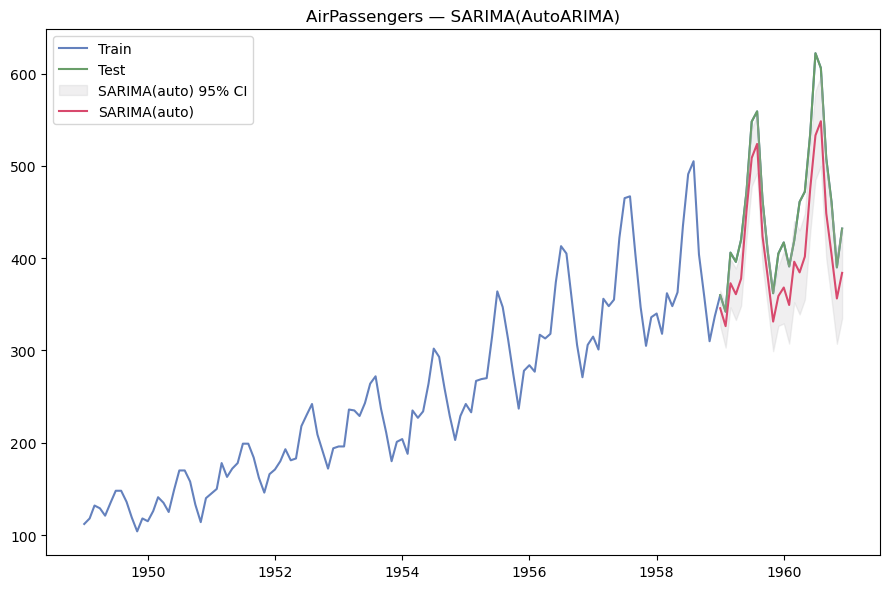

In [13]:
fc_sarima, ci = sarima.predict(n_periods=len(y_test), return_conf_int=True, alpha=0.05)
fc_sarima = as_series(fc_sarima, y_test.index, "SARIMA(auto)")
ci_sarima = pd.DataFrame(np.asarray(ci), index=y_test.index, columns=["lower","upper"]).astype(float)

print_scores("SARIMA(auto)", y_test, fc_sarima)
plot_model("AirPassengers ‚Äî SARIMA(AutoARIMA)", y, y_test, fc_sarima, ci_sarima)

#### Seasonal Naive
- Îã§Ïùå Í∞í = ÏûëÎÖÑ Í∞ôÏùÄ Îã¨Ïùò Í∞í
- Ïù¥Î°†Ï†ÅÏúºÎ°ú SARIMA(0,0,0)(0,1,0)_m ÏôÄ ÎèôÏùºÌïú Í∑πÎã®Ï†Å ÌòïÌÉú
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Í∞ïÌïú Í≥ÑÏ†à ÏßÄÏÜçÏÑ± + ÏßßÏùÄ ÏòàÏ∏° ÏãúÍ≥ÑÏóêÏÑú Í∞ïÌï®
  - Ìï≠ÏÉÅ ÎÑ£Îäî ÏµúÏÜå Í∏∞Ï§ÄÏÑ†
- Ïû•Îã®Ï†ê
  - ÏÑ§Î™ÖÎ†• Ï†ÑÎ¨¥ÌïòÏßÄÎßå Íπ®ÏßÄÍ∏∞ Ïñ¥Î†§Ïö¥ baseline
  - Ï∂îÏÑ∏/Ï∂©Í≤©/Íµ¨Ï°∞ Î≥ÄÌôî Î∞òÏòÅ Î™ªÌï®

[SeasonalNaive]  RMSE=49.987  MAPE=10.52%  sMAPE=11.17%


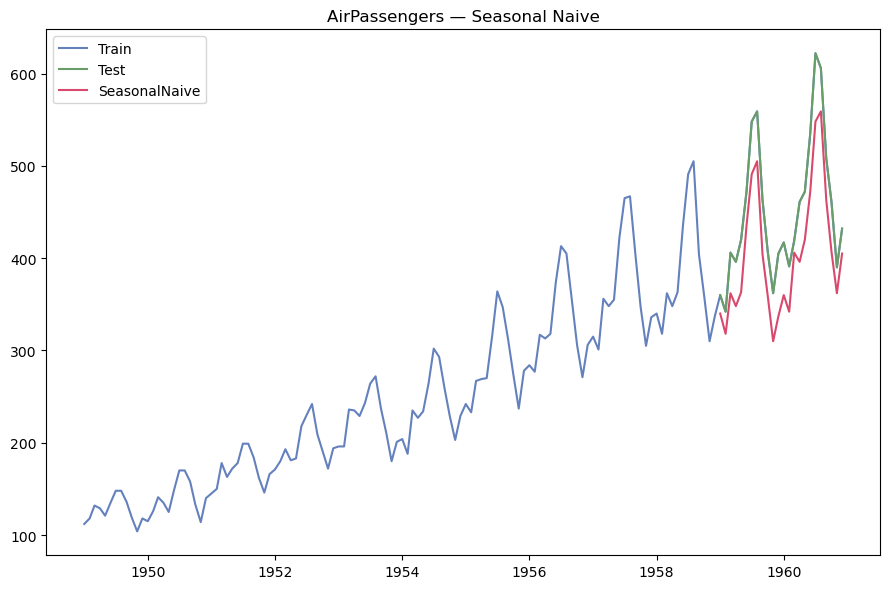

In [14]:
fc_snaive = y.shift(m).reindex(y_test.index).astype(float).rename("SeasonalNaive")
print_scores("SeasonalNaive", y_test, fc_snaive)
plot_model("AirPassengers ‚Äî Seasonal Naive", y, y_test, fc_snaive)

#### ThetaModel
- ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥
  - ÏãúÍ≥ÑÎ•º Îëê Í∞úÏùò ÏÑ∏ÌÉÄ ÏÑ†ÏúºÎ°ú Î∂ÑÎ¶¨Ìï¥ Í≤∞Ìï©(ÏàòÏ§Ä Î≥¥Ï†ï + Ï∂îÏÑ∏ Î≥¥Ï†ï)
  - Ïù¥Î°†Ï†ÅÏúºÎ°ú SES(ETS A,N,N)+drift ÏôÄ, Îòê Í∑∏Í≤ÉÏù¥ ARIMA(0,1,1)+driftÏôÄ Í±∞Ïùò ÎèôÏπò
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Í∞ïÎ†•Ìïú Í∏∞Ï§ÄÏÑ†(baseline) Ïù¥ ÌïÑÏöîÌï† Îïå
  - deseasonalize=True(ÏßÄÏõê Ïãú)Î°ú Í≥ÑÏ†à Ï†úÍ±∞ ÌõÑ Ïì∞Î©¥ ÍπîÎÅî
- Ïû•Ï†ê/Ï£ºÏùò
  - Ï¥àÍ∞ÑÎã®¬∑Îß§Ïö∞ Îπ†Î¶Ñ, ÌäúÎãù Ï†ÅÏùå
  - Î≥µÏû°Ìïú Í≥ÑÏ†à/ÎπÑÏÑ†ÌòïÏóêÎäî ÌïúÍ≥Ñ ‚Üí ETS/TBATS/SARIMAÏôÄ Í∞ôÏù¥ ÎπÑÍµê

[Theta]  RMSE=71.361  MAPE=13.34%  sMAPE=14.48%


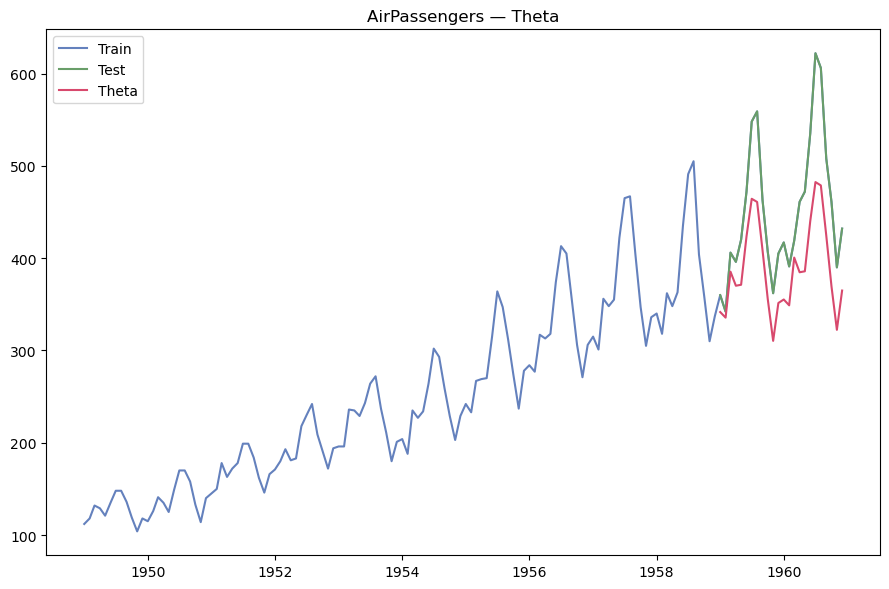

In [15]:
theta_kwargs = {}
if "deseasonalize" in signature(ThetaModel).parameters:
    theta_kwargs["deseasonalize"] = True   

theta = ThetaModel(y_train, period=m, **theta_kwargs).fit()
fc_theta = as_series(theta.forecast(len(y_test)), y_test.index, "Theta")
print_scores("Theta", y_test, fc_theta)
plot_model("AirPassengers ‚Äî Theta", y, y_test, fc_theta)

#### ETS (Exponential Smoothing: Error‚ÄìTrend‚ÄìSeasonal)
- ÏÉÅÌÉúÍ≥µÍ∞Ñ ÌòïÌÉúÎ°ú ÏàòÏ§Ä/Ï∂îÏÑ∏/Í≥ÑÏ†àÏùÑ ÏßÅÏ†ë Í∞±Ïã†
- Ïò§Î•ò¬∑Ï∂îÏÑ∏¬∑Í≥ÑÏ†àÏùÑ A(dditive)/M(ultiplicative)/NoneÏúºÎ°ú Ï°∞Ìï©
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Î≥ÄÎèôÏù¥ ÏµúÍ∑º Í∞íÏóê Îçî ÎØºÍ∞êÌïòÍ≥†, Í≥ÑÏ†à/Ï∂îÏÑ∏Í∞Ä ÎöúÎ†∑Ìï† Îïå
  - ÏûêÎèôÌôîÍ∞Ä ÏâΩÍ≥† Îπ†Î•∏ Î≤†Ïù¥Ïä§ÎùºÏù∏
- Ïû•Ï†ê
  - Îß§ÎÅÑÎüΩÍ≥† ÏßÅÍ¥ÄÏ†Å, ÌäúÎãù ÌååÎùºÎØ∏ÌÑ∞(Œ±,Œ≤,Œ≥,œÜ) Ìï¥ÏÑù Í∞ÄÎä•
  - Î≥µÏû°Ìïú AR Íµ¨Ï°∞ ÏóÜÏù¥ÎèÑ Í≥ÑÏ†à/Ï∂îÏÑ∏Î•º Ïûò Ï∂îÏ†Å
- Ï£ºÏùò/ÌäúÎãù
  - Ïò§Ï∞®Ïùò ÏûêÎèôÏÉÅÍ¥ÄÏùÄ Î™ÖÏãúÏ†ÅÏúºÎ°ú Î™®Îç∏ÎßÅÌïòÏßÄ ÏïäÏùå(Í∑∏Í≤å Í∞ïÌïòÎ©¥ ARIMAÍ∞Ä Ïú†Î¶¨)
  - Í∞ÄÎ≥Ä ÏßÑÌè≠Ïóî Í≥±ÏÖàÌòïÏùÑ, Ïù¥ÏÉÅÏπòÏóî Í∞ïÍ±¥ ÏòµÏÖò/ÏúàÏ†ÄÎùºÏù¥Ïßï Í≥†Î†§

[ETS(mul-mul)]  RMSE=12.917  MAPE=2.52%  sMAPE=2.54%


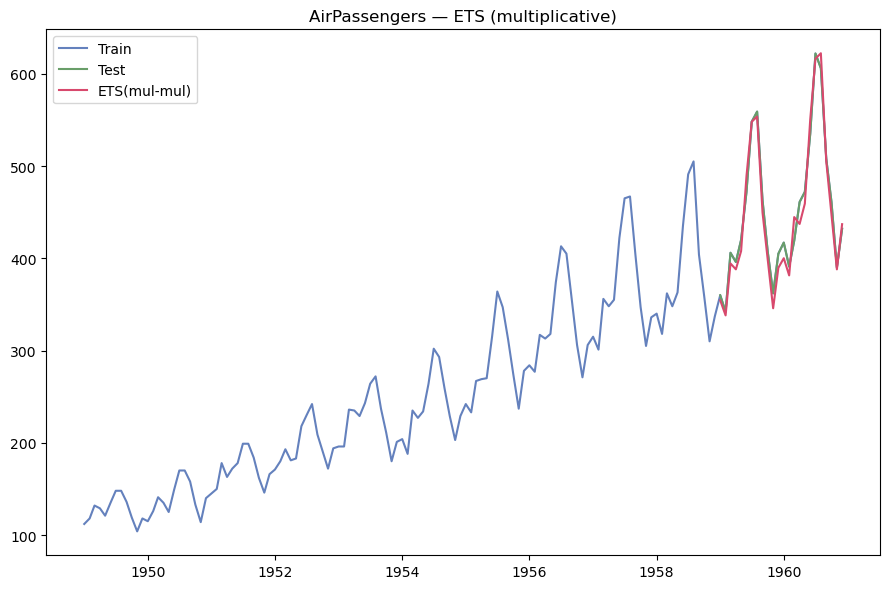

In [16]:
ets = ExponentialSmoothing(y_train, trend="mul", damped_trend=True, seasonal="mul", 
                           seasonal_periods=m, initialization_method="estimated").fit(optimized=True)

fc_ets = as_series(ets.forecast(len(y_test)), y_test.index, "ETS(mul-mul)")
print_scores("ETS(mul-mul)", y_test, fc_ets)
plot_model("AirPassengers ‚Äî ETS (multiplicative)", y, y_test, fc_ets)

#### UCM (Unobserved Components, Íµ¨Ï°∞Ï†Å ÏãúÍ≥ÑÏó¥)
- ÏπºÎßå ÌïÑÌÑ∞Î°ú ÏàòÏ§Ä(level)/Ï∂îÏÑ∏(trend)/Í≥ÑÏ†à(seasonal)/ÏàúÌôò(cycle) Îì±ÏùÑ Î∂ÑÌï¥Ìï¥ Ï∂îÏ†ï
- Í∞Å Íµ¨ÏÑ±ÏöîÏÜåÎ•º Í≤∞Ï†ïÏ†Å/ÌôïÎ•†Ï†Å(stochastic) ÏúºÎ°ú ÏÑ†ÌÉù Í∞ÄÎä•, ÎåêÌïë(damped)ÎèÑ Í∞ÄÎä•
- ÌöåÍ∑ÄÌï≠(Ïô∏ÏÉùÎ≥ÄÏàò)ÎèÑ ÏâΩÍ≤å Ï∂îÍ∞Ä
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Íµ¨Ï°∞Í∞Ä Î≥¥Ïù¥Îäî ÏòàÏ∏° : Í∞Å Íµ¨ÏÑ±ÏöîÏÜåÎ•º Ìï¥ÏÑùÌïòÍ≥† Ïã∂ÏùÑ Îïå
  - Ï†êÏßÑÏ†Å Íµ¨Ï°∞ Î≥ÄÌôî, Íµ≠ÏÜåÏ†Å Ï∂îÏÑ∏Ïóê Í∞ïÌï®
- Ïû•Îã®Ï†ê
  - Ìï¥ÏÑùÎ†• / Ïú†Ïó∞ÏÑ± ÎÜíÏùå
  - Íµ¨ÏÑ±ÏöîÏÜåÍ∞Ä ÎßéÏúºÎ©¥ Í≥ºÏ†ÅÌï©¬∑ÏàòÎ†¥ Î¨∏Ï†ú ‚Üí Í∞ÑÍ≤∞ÌïòÍ≤å ÏãúÏûë
- Ï£ºÏùò
  - Î°úÍ∑∏(ÎòêÎäî Box‚ÄìCox) / Ïó≠Î≥ÄÌôò Ï≤òÎ¶¨ 

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `stochastic_level` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `stochastic_trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


[UCM(log)]  RMSE=32.582  MAPE=5.77%  sMAPE=5.97%


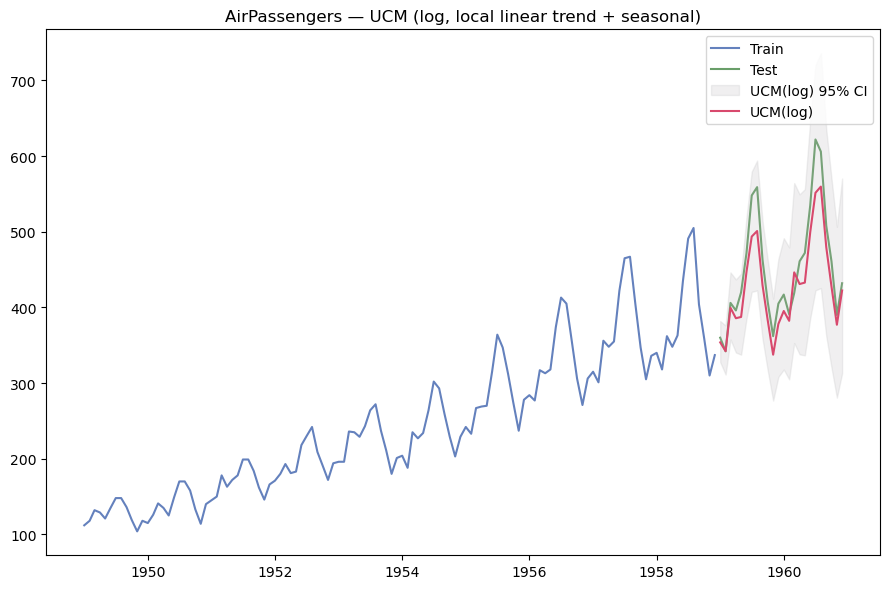

In [17]:
ytr_log = np.log(y_train)
ucm_log = UCM(ytr_log, level="local linear trend", seasonal=12, damped_trend=True, 
              stochastic_level=True, stochastic_trend=True, stochastic_seasonal=True).fit(disp=False)

pred = ucm_log.get_forecast(steps=len(y_test))
fc_log = pred.predicted_mean
ci_log = pred.conf_int(alpha=0.05)      

fc_ucm  = pd.Series(np.exp(fc_log.values), index=y_test.index, name="UCM(log)")
ci_ucm  = pd.DataFrame({"lower": np.exp(ci_log.iloc[:, 0].values),
                        "upper": np.exp(ci_log.iloc[:, 1].values)}, index=y_test.index)

print_scores("UCM(log)", y_test, fc_ucm)
plot_model("AirPassengers ‚Äî UCM (log, local linear trend + seasonal)",
           y_train, y_test, fc_ucm, ci_ucm)

#### BATS / TBATS (Îã§Ï§ë Í≥ÑÏ†àÏÑ±)
- **B**ox‚ÄìCox + **A**RMA errors + **T**rend(+damped) + **S**easonality(ÏÇºÍ∞ÅÌï®Ïàò)
- TBATSÎäî Îã§Ï§ë/Í∏¥ Ï£ºÍ∏∞(Ïòà: 7¬∑365.25 Í∞ôÏù¥ Ïó¨Îü¨ Ï£ºÍ∏∞)Î•º ÎèôÏãúÏóê Îã§Î£∏
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Ïó¨Îü¨ Í≥ÑÏ†àÏÑ±(ÌïòÎ£®¬∑Ï£º¬∑Ïó∞), ÎπÑÏ†ïÏàò Ï£ºÍ∏∞ÎÇò Í∏¥ Ï£ºÍ∏∞Í∞Ä ÏûàÎäî Îç∞Ïù¥ÌÑ∞
  - Î≥µÏû° Í≥ÑÏ†à Íµ¨Ï°∞ÏóêÏÑú ETS/SARIMAÎ≥¥Îã§ Ïú†Î¶¨Ìï† ÎïåÍ∞Ä ÎßéÏùå
- Ï£ºÏùò
  - ÎπÑÍµêÏ†Å ÌïôÏäµÏù¥ Î¨¥Í≤ÅÍ≥† ÏûëÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≥ºÏ†ÅÌï© Ïö∞Î†§
  - Í∏∞Î≥∏ÏùÄ Í∞ÄÎ≤ïÏù¥ÏßÄÎßå Box-CoxÎ°ú Í≥±ÏÖàÏ†Å Ìå®ÌÑ¥Ïóê ÎåÄÏùë

[TBATS]  RMSE=70.267  MAPE=12.83%  sMAPE=13.93%


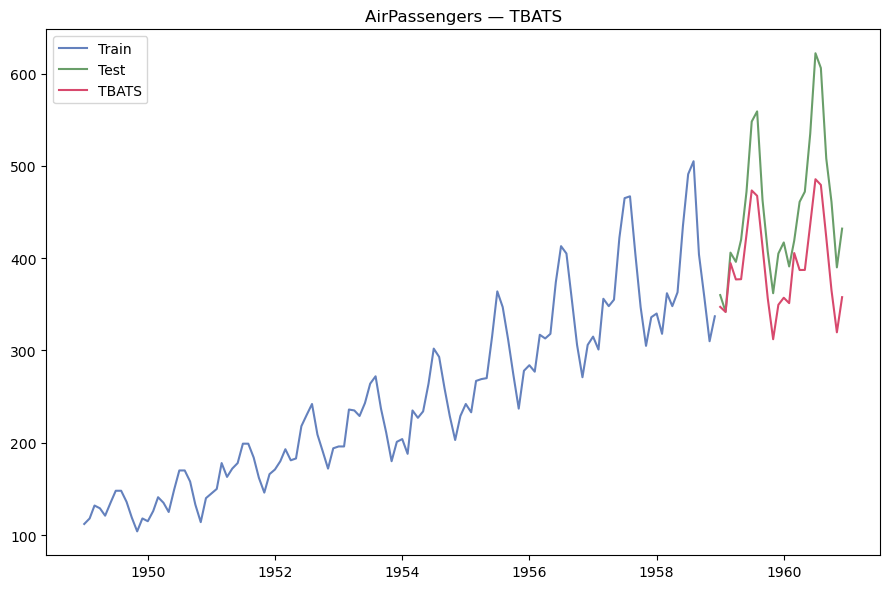

In [18]:
tbats_model = TBATS(seasonal_periods=[12], use_box_cox=True, use_trend=True,
                    use_damped_trend=True).fit(y_train)

fc_tbats = as_series(tbats_model.forecast(steps=len(y_test)), y_test.index, "TBATS")
print_scores("TBATS", y_test, fc_tbats)
plot_model("AirPassengers ‚Äî TBATS", y_train, y_test, fc_tbats)

[TBATS] selected by AIC = 1115.68
Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.781297
Trend (Beta): 0.041725
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-3.63131730e-07  1.58685703e-07]
AR coefficients []
MA coefficients []
Seed vector [ 4.81008337 -0.00813542 -0.14212595  0.05389597 -0.01044897  0.00814232
  0.00502465  0.02934449  0.06104935 -0.02634057 -0.03503377 -0.02082088]

AIC 1115.675665
[TBATS(best)]  RMSE=57.240  MAPE=10.32%  sMAPE=11.03%


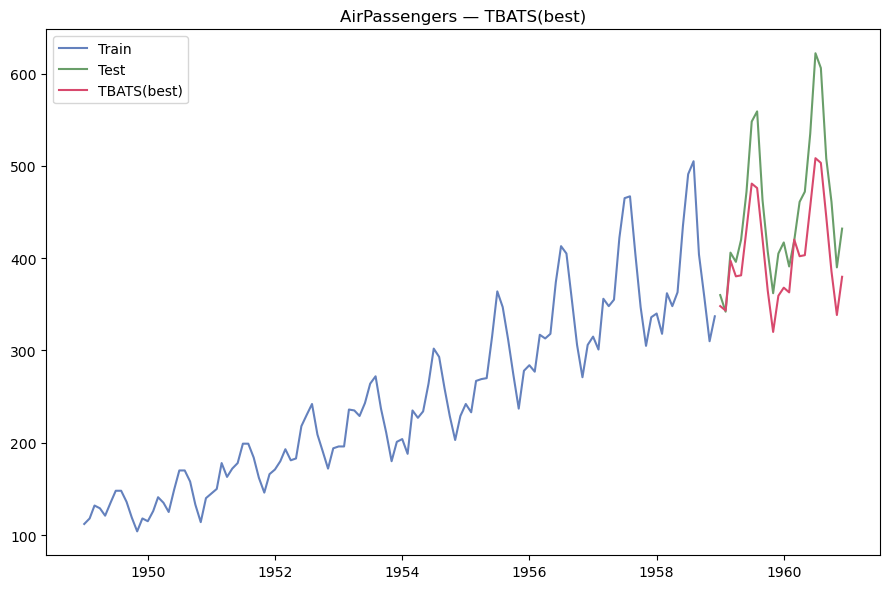

In [19]:
candidates = [TBATS(seasonal_periods=[12], use_box_cox=True, use_arma_errors=True),            
              TBATS(seasonal_periods=[12], use_box_cox=True, use_trend=True,
                    use_damped_trend=True, use_arma_errors=True),                              
              TBATS(seasonal_periods=[24], use_box_cox=True, use_arma_errors=True),                                                   
              BATS(seasonal_periods=[12], use_box_cox=True, use_arma_errors=True)]

best_fit, best_name, best_aic = None, None, float('inf')
for model in candidates:
    fit = model.fit(y_train)
    if fit.aic < best_aic:
        best_fit, best_aic = fit, fit.aic
        best_name = type(model).__name__

print(f"[{best_name}] selected by AIC = {best_aic:.2f}")
print(best_fit.summary()) 

fc_best = pd.Series(best_fit.forecast(steps=len(y_test)), index=y_test.index, name=f"{best_name}(best)")
print_scores(f"{best_name}(best)", y_test, fc_best)
plot_model(f"AirPassengers ‚Äî {best_name}(best)", y_train, y_test, fc_best)

#### STL + ARIMA
- STL(LOESSÎ°ú Í∞ïÍ±¥Ìïú Í≥ÑÏ†à Î∂ÑÌï¥)Î°ú Í≥ÑÏ†àÏÑ± Ï†úÍ±∞ ‚Üí ÎÇòÎ®∏ÏßÄ(Ï∂îÏÑ∏/Î∂àÍ∑úÏπô)Ïóê ARIMA Ï†ÅÌï© ‚Üí ÏòàÏ∏° ÌõÑ Í≥ÑÏ†à ÏÑ±Î∂Ñ Ïû¨Ìï©ÏÑ±
- ÏÑ†ÌÉù Í∏∞Ï§Ä 
  - Í≥ÑÏ†à Ìå®ÌÑ¥Ïù¥ ÏÑúÏÑúÌûà Î≥ÄÌòïÎêòÍ±∞ÎÇò, Ïù¥ÏÉÅÏπò/Ï∂îÏÑ∏Í∞Ä Îí§ÏÑûÏù∏ Í≤ΩÏö∞
  - Î∂ÑÌï¥Í∞Ä Î™ÖÌôïÌïòÏó¨ Ìï¥ÏÑù¬∑ÎîîÎ≤ÑÍπÖÏù¥ Ïâ¨ÏõÄ
- ÌåÅ
  - Í≥±ÏÖàÏ†ÅÏù¥Î©¥ Î°úÍ∑∏ ÌõÑ STL(additive Î∂ÑÌï¥) ‚Üí Ïó≠Î≥ÄÌôò
  - ÏúàÎèÑÏö∞/Í∞ïÍ±¥ ÏòµÏÖòÏúºÎ°ú Í≥ÑÏ†à Î≥ÄÌôîÏóê ÎåÄÏùë

[STL+ARIMA(1,1,1)]  RMSE=73.093  MAPE=14.36%  sMAPE=15.68%


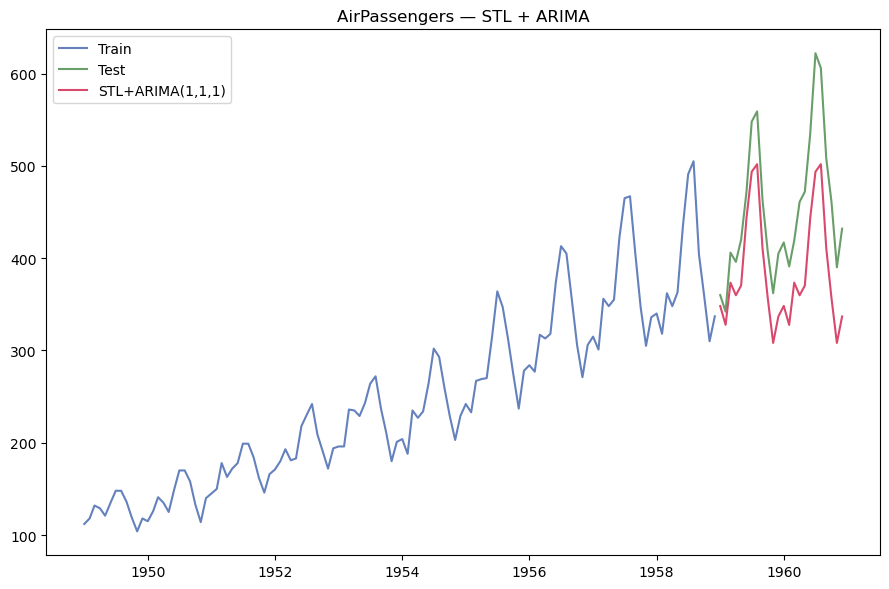

In [20]:
stl_arima = STLForecast(y_train, ARIMA, period=12, model_kwargs={"order": (1, 1, 1)}).fit()

fc_stl_arima = as_series(stl_arima.forecast(len(y_test)), y_test.index, "STL+ARIMA(1,1,1)")
print_scores("STL+ARIMA(1,1,1)", y_test, fc_stl_arima)
plot_model("AirPassengers ‚Äî STL + ARIMA", y_train, y_test, fc_stl_arima)

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Adm

       order trend       RMSE   MAPE(%)  sMAPE(%)
0  (2, 1, 2)     t  18.290620  3.462211  3.543922
1  (1, 1, 2)     t  18.373034  3.473876  3.556417
2  (1, 1, 1)     t  18.630441  3.521235  3.606479
3  (0, 1, 2)     t  18.836814  3.566130  3.653582
4  (0, 1, 1)     t  19.522531  3.728211  3.823036
5  (2, 1, 1)     t  19.557178  3.736362  3.831535
6  (2, 0, 1)     c  20.056347  3.849361  3.949361
7  (2, 1, 0)     t  20.556299  3.966022  4.072265
8  (1, 1, 0)     t  21.069784  4.094866  4.206922
9  (0, 1, 0)     t  22.193341  4.372036  4.497167
Best: (2, 1, 2) trend: t RMSE: 18.291
[STL+ARIMA(2, 1, 2)(log,t)]  RMSE=18.291  MAPE=3.46%  sMAPE=3.54%


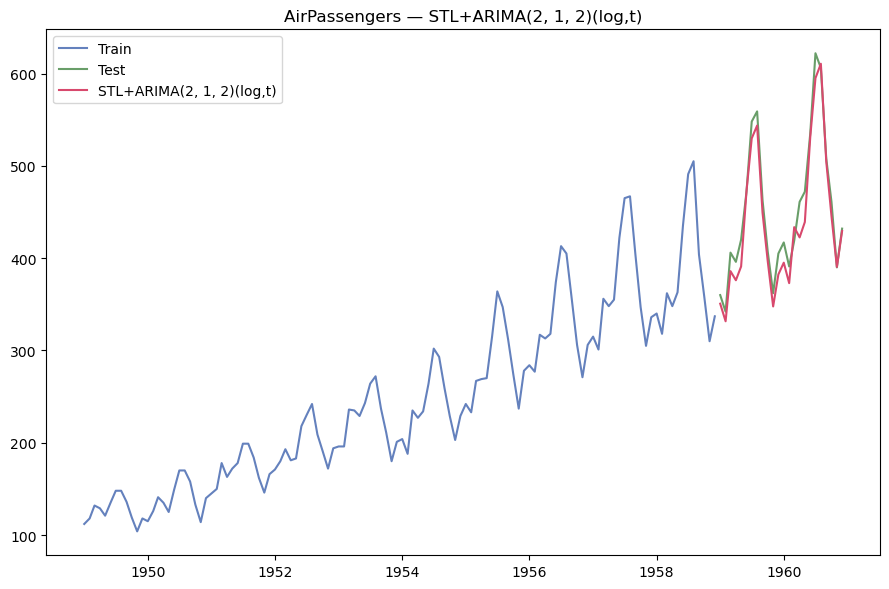

In [23]:
ytr_log = np.log(y_train)
orders = [(p,d,q) for p in [0,1,2] for d in [0,1] for q in [0,1,2] if not (p==0 and d==0 and q==0)]

best = None
rows = []

for (p, d, q) in orders:
    trend_opt = "c" if d == 0 else "t"  
    fit = STLForecast(ytr_log, ARIMA, period=12, robust=True,
                      model_kwargs={"order": (p, d, q), "trend": trend_opt, "enforce_stationarity": False,
                                    "enforce_invertibility": False}).fit()

    fc_log = fit.forecast(len(y_test))
    fc = pd.Series(np.exp(np.asarray(fc_log).ravel()),
                   index=y_test.index, name=f"STL+ARIMA{(p,d,q)}")

    r = rmse(y_test, fc); m = mape(y_test, fc); s = smape(y_test, fc)
    rows.append({"order": (p, d, q), "trend": trend_opt,
                 "RMSE": r, "MAPE(%)": m, "sMAPE(%)": s, "fc": fc})

    if (best is None) or (r < best["RMSE"]):
        best = rows[-1]

score_stl = pd.DataFrame(rows).drop(columns="fc").sort_values("RMSE").reset_index(drop=True)
print(score_stl.head(10))
print("Best:", best["order"], "trend:", best["trend"], "RMSE:", round(best["RMSE"], 3))

fc_stl_arima_best = best["fc"].rename(f"STL+ARIMA{best['order']}(log,{best['trend']})")
print_scores(fc_stl_arima_best.name, y_test, fc_stl_arima_best)
plot_model(f"AirPassengers ‚Äî {fc_stl_arima_best.name}", y_train, y_test, fc_stl_arima_best)

#### Î™®Îç∏ ÎπÑÍµê
- ETS(mul‚Äìmul) ‚Äî 1ÏúÑ
  - AirPassengersÎäî ÏàòÏ§Ä‚Üë ‚áí Í≥ÑÏ†à ÏßÑÌè≠ÎèÑ ‚Üë Ïù∏ Í≥±ÏÖàÌòï Í≥ÑÏ†àÏÑ±Ïù¥Îùº ETSÏùò M‚ÄìM Íµ¨Ï°∞Ïóê Ï†ÅÌï©
  - ÏµúÍ∑º Í¥ÄÏ∏°Ïóê Îçî ÌÅ∞ Í∞ÄÏ§ëÏùÑ Ï£ºÎäî ÏßÄÏàò ÌèâÌôú ÌäπÏÑ± 
- STL+ARIMA (Î°úÍ∑∏, ÌäúÎãù) ‚Äî 2ÏúÑ
  - Î°úÍ∑∏ ‚Üí STL(Í∞ÄÎ≤ï Î∂ÑÌï¥) Î°ú Í≥ÑÏ†àÏùÑ Ï†úÍ±∞ÌïòÍ≥†, ÎÇ®ÏùÄ ÎπÑÍ≥ÑÏ†à ÏÑ±Î∂ÑÏùÑ ÏûëÏùÄ Ï∞®Ïàò ARIMAÎ°ú Ïû°ÏïÑÏ§å
  - Í≥ÑÏ†à/Ï∂îÏÑ∏Î•º ÏßÅÏ†ë ÏÉÅÌÉúÎ°ú Ï∂îÏ†ÅÌïòÎäî ETSÎßåÌÅº ÎØºÏ≤©ÌïòÏßÑ ÏïäÏùå
- UCM(log) ‚Äî 3ÏúÑ
  - Î°úÍ∑∏ Ïä§ÏºÄÏùºÏóêÏÑú ÏàòÏ§Ä/Ï∂îÏÑ∏/Í≥ÑÏ†àÏùÑ ÏÉÅÌÉúÍ≥µÍ∞ÑÏúºÎ°ú Î∂ÑÌï¥¬∑Ï∂îÏ†Å   
    ‚Üí Íµ¨Ï°∞Ï†Å Ïú†Ïó∞ÏÑ±ÏùÄ ÌÅ¨ÏßÄÎßå, ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Í∞Ä Í∏∏ÏßÄ ÏïäÏïÑ ETS ÎåÄÎπÑ ÎØºÍ∞êÎèÑÏóêÏÑú ÏïΩÍ∞Ñ Î∞ÄÎ¶º
- SARIMA(boxcox, auto) ‚Äî Ï§ëÏúÑÍ∂å
  - ÏÑ†ÌÉùÎêú Î™®ÌòïÏù¥ (2,0,0)(0,1,0)[12]Ï≤òÎüº Í≥ÑÏ†à AR/MAÍ∞Ä ÏóÜÎäî Îã®Ïàú Íµ¨Ï°∞   
    Í≥ÑÏ†àÏ∞®Î∂Ñ(D=1) ÌõÑ AR(2)ÎßåÏúºÎ°úÎäî Ï¶ùÍ∞ÄÌïòÎäî ÏßÑÌè≠Í≥º ÌîºÌÅ¨Î•º ÏïΩÍ∞Ñ Í≥ºÏÜåÏ∂îÏ†ï
- Seasonal Naive ‚Äî Î≤†Ïù¥Ïä§ÎùºÏù∏
  - Ï∂îÏÑ∏ Í∞ÄÏÜçÏùÑ Î∞òÏòÅ Î™ª Ìï¥ Ï§ëÏúÑÍ∂å
- TBATS(best) ‚Äî ÌïòÏúÑÍ∂å
  - Ïû•Ï†êÏùÄ Îã§Ï§ë/Í∏¥/ÎπÑÏ†ïÏàò Í≥ÑÏ†àÏÑ±ÏóêÏÑú ÎÇòÏò§ÎäîÎç∞, Ïù¥ Îç∞Ïù¥ÌÑ∞Îäî Îã®Ïùº 12Í∞úÏõî Í≥ÑÏ†àÏù¥Îùº Ïù¥Ï†êÏùÑ Î™ª ÏÇ¥Î¶º
  - ÏûêÎèôÏÑ†ÌÉù Í≤∞Í≥ºÎèÑ ARMA-errorsÍ∞Ä 0,0Ïù¥Îùº Îã®ÏàúÌï¥Ïßê
- Theta ‚Äî ÌïòÏúÑÍ∂å
  - Í∏âÍ≤©Ìûà Ïª§ÏßÄÎäî ÏßÑÌè≠Ïóî ÌïúÍ≥Ñ


========== Model Score Comparison ==========
        Model      RMSE   MAPE(%)  sMAPE(%)
 ETS(mul-mul) 12.916587  2.524553  2.540212
    STL+ARIMA 18.290620  3.462211  3.543922
          UCM 32.581875  5.772090  5.971218
 SARIMA(auto) 47.226392  9.439333  9.968721
SeasonalNaive 49.986665 10.522728 11.166613
        TBATS 57.240471 10.323493 11.030867
        Theta 71.360963 13.343084 14.476361


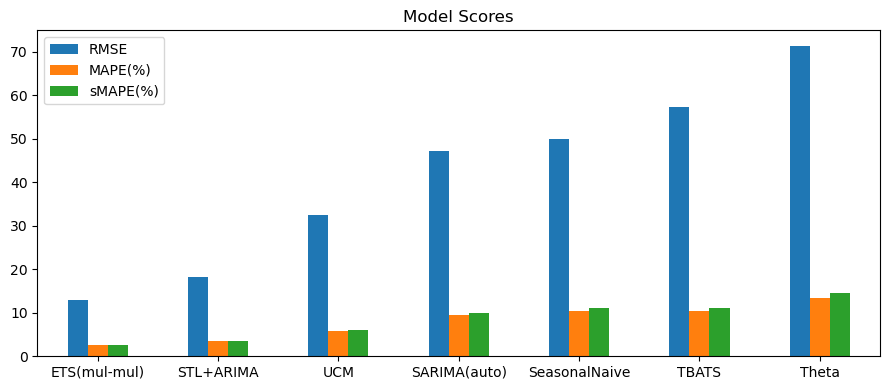

In [24]:
def collect_scores(y_test, preds_dict):
    rows = []
    for name, pred in preds_dict.items():
        s = pd.Series(np.asarray(getattr(pred, "values", pred)).ravel(),
                      index=y_test.index, name=name, dtype="float64")
        rows.append({"Model": name, "RMSE": rmse(y_test, s),
                     "MAPE(%)": mape(y_test, s), "sMAPE(%)": smape(y_test, s)})
    df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
    return df

preds_dict = {"SARIMA(auto)": fc_sarima, "SeasonalNaive": fc_snaive, "Theta": fc_theta, 
              "ETS(mul-mul)": fc_ets, "UCM":fc_ucm , "TBATS":fc_best, "STL+ARIMA":fc_stl_arima_best}

score_df = collect_scores(y_test, preds_dict)
print("\n========== Model Score Comparison ==========")
print(score_df.to_string(index=False))

ax = score_df.set_index("Model")[["RMSE","MAPE(%)","sMAPE(%)"]].plot(kind="bar", figsize=(9,4))
ax.set_title("Model Scores")
ax.set_xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Î≥ÄÎèôÏÑ± Î™®Îç∏(GARCH)
- AirPassengers ÏõîÎ≥Ñ Î°úÍ∑∏ÏàòÏùµÎ•† r = 100*np.log(y).diff()ÏóêÎäî Î≥¥ÌÜµ Í∏àÏúµÏãúÍ≥ÑÏó¥Ï≤òÎüº Í∞ïÌïú Î≥ÄÎèôÏÑ± ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ ÏóÜÏùå

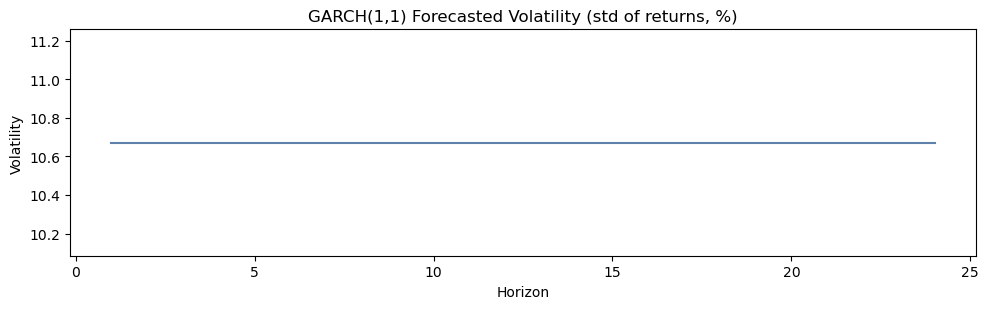

In [25]:
r = 100 * np.log(y).diff().dropna()
garch = arch_model(r, mean="Constant", vol="GARCH", p=1, q=1, dist="t").fit(disp="off")
vol = np.sqrt(garch.forecast(horizon=len(y_test), reindex=False).variance.values[-1])

plt.figure(figsize=(10,3.2))
plt.plot(range(1, len(y_test)+1), vol, color="#5E81AC")
plt.title("GARCH(1,1) Forecasted Volatility (std of returns, %)")
plt.xlabel("Horizon")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()

---

# 2. sp500 Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ïù¥Ïö©Ìïú Í∏àÏúµ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° 

### Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [26]:
data = sp500.load()                                
prices = data['Adj Close'].dropna()
r = 100 * np.log(prices).diff().dropna()  

### Train / Test Split

In [27]:
test_len = 500
h = 50
r_train, r_test = r.iloc[:-test_len], r.iloc[-test_len:]

print("Train:", r_train.index.min().date(), "‚Üí", r_train.index.max().date(), "| N:", len(r_train))
print("Test :", r_test.index.min().date(),  "‚Üí", r_test.index.max().date(),  "| N:", len(r_test))

Train: 1999-01-05 ‚Üí 2017-01-04 | N: 4530
Test : 2017-01-05 ‚Üí 2018-12-31 | N: 500


### ARCH Ìö®Í≥º Í≤ÄÏ†ï(Train)
- ARCH LM p-value = 2.971e-269
  - Í∑ÄÎ¨¥Í∞ÄÏÑ§(Ï°∞Í±¥Î∂Ä Ïù¥Î∂ÑÏÇ∞ ÏóÜÏùå)ÏùÑ Í∞ïÌïòÍ≤å Í∏∞Í∞Å
  - ARCH Ìö®Í≥ºÍ∞Ä Îß§Ïö∞ Í∞ïÌï® = Î≥ÄÎèôÏÑ± ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ï°¥Ïû¨
- Ljung‚ÄìBox on r¬≤ (lags 10, 20) p-value = 0.0
  - Ï†úÍ≥±ÏàòÏùµÎ•†Ïóê Ïú†ÏùòÌïú ÏûêÍ∏∞ÏÉÅÍ¥ÄÏù¥ ÎÇ®ÏïÑ ÏûàÏùå
  - Î≥ÄÎèôÏÑ±Ïù¥ ÏãúÍ∞ÑÏóê Îî∞Îùº Î¨∂Ïó¨ ÏõÄÏßÅÏù∏Îã§Îäî Ï∂îÍ∞Ä Ï¶ùÍ±∞

In [28]:
# ARCH LM: Ï°∞Í±¥Î∂Ä Ïù¥Î∂ÑÏÇ∞(Î≥ÄÎèôÏÑ± ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ) Ïú†Î¨¥
lm_stat, lm_pval, _, _ = het_arch(r_train, nlags=12)

# Ï†úÍ≥±ÏàòÏùµÎ•†Ïùò Ljung‚ÄìBox: Î≥ÄÎèôÏÑ± ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Ïã†Ìò∏
print(f"ARCH LM p-value (12 lags): {lm_pval:.4g}")
print("LB test on squared returns:\n", acorr_ljungbox(r_train**2, lags=[10, 20], return_df=True))

ARCH LM p-value (12 lags): 2.971e-269
LB test on squared returns:
         lb_stat  lb_pvalue
10  3682.305467        0.0
20  6332.406392        0.0


### Î™®Îç∏ Ï†ÅÌï©
- index-safe: last_obs=r_train.index[-1]
- Ï†ÑÏ≤¥ rÏóê ÎåÄÌï¥ Ï†ÅÌï©ÌïòÎêò, Ï∂îÏ†ïÏùÄ last_obsÍπåÏßÄÎ°ú Ï†úÌïú ‚Üí ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä DatetimeIndexÎ°ú Ï†ïÎ†¨Îê®

In [29]:
# GARCH(1,1) + t-Î∂ÑÌè¨
arch1 = arch_model(r, mean='Constant', vol='ARCH', p=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

# ÎπÑÍµêÏö©: ARCH(1)
garch11 = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

### Î™®Îç∏ ÎπÑÍµê
- Î™®Ìòï ÏÑ†ÌÉù (AIC/BIC) ‚Üí GARCH
  - AIC/BIC Ï∞®Ïù¥Í∞Ä 800+: ÏïïÎèÑÏ†Å Ïö∞ÏúÑ(>10Ïù¥Î©¥ Í∞ïÌïú Ï¶ùÍ±∞)
- GARCH(1,1) Ï∂îÏ†ïÏπò Ìï¥ÏÑù
  - Mean(Œº) = 0.0602 (Îã®ÏúÑ: %/day), p‚â™0.01 ‚Üí Ïú†Ïùò   
    Ïó∞ÌôòÏÇ∞ ÎåÄÎûµ 15% (0.0602√ó252)
  - Volatility model (GARCH)
    - œâ=0.0136, Œ±‚ÇÅ=0.0186, Œ≤‚ÇÅ=0.8964 (Î™®Îëê Ïú†Ïùò)
    - ÏßÄÏÜçÏÑ± Œ±+Œ≤ ‚âà 0.915 ‚Üí Ï∂©Í≤©Ïùò Ïó¨Ïö¥Ïù¥ Îß§Ïö∞ ÏßÄÏÜçÏ†Å(ÌïòÏßÄÎßå <1Ïù¥ÎØÄÎ°ú Ï†ïÏÉÅÏÑ± Ïú†ÏßÄ)
    - Ïû•Í∏∞ Î∂ÑÏÇ∞/Î≥ÄÎèôÏÑ±   
      $\sigma_\infty^2 = \frac{0.0136}{1-0.915} = 0.1600, \qquad \sigma_\infty   = \sqrt{0.1600} = 0.40\%, \qquad \sigma_{\text{ann}} = \sqrt{252}\times 0.40\% \approx 6.35\%$
- Î∂ÑÌè¨: Student‚Äôs t, df‚âà7.4 ‚Üí Íº¨Î¶¨Í∞Ä ÎëêÍ∫ºÏõÄ(Ï†ïÍ∑úÎ≥¥Îã§ Í∑πÎã®Í∞í ÎπàÎèÑ ÌÅº)
- Covariance estimator: robust ‚Üí ÌëúÏ§ÄÏò§Ï∞®Î•º Í∞ïÍ±¥ÌïòÍ≤å Í≥ÑÏÇ∞

In [30]:
comp = pd.DataFrame({"AIC": [arch1.aic, garch11.aic], "BIC": [arch1.bic, garch11.bic]}, 
                    index=["ARCH(1)", "GARCH(1,1)"])

print("=========== Model comparison ==========")
print(comp)

print("\nGARCH(1,1) summary (truncated):")
print(garch11.summary())

=========== Model comparison ==========
                     AIC           BIC
ARCH(1)     13576.573527  13602.246553
GARCH(1,1)  12748.507789  12780.599071

GARCH(1,1) summary (truncated):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6369.25
Distribution:      Standardized Student's t   AIC:                           12748.5
Method:                  Maximum Likelihood   BIC:                           12780.6
                                              No. Observations:                 4529
Date:                      Thu, Sep 11 2025   Df Residuals:                     4528
Time:                              17:02:56   Df Model:                            1
                                 Mean Model  

### Ï°∞Í±¥Î∂Ä Î≥ÄÎèôÏÑ±(1-step) Í≤ΩÎ°ú & h-step ÏòàÏ∏°

In [31]:
# Ïù∏Îç±Ïä§ ÏïàÏ†ÑÏÑ± : last_obsÎ°ú ÌïôÏäµÍµ¨Í∞ÑÏùÑ Í≥†Ï†ï, ÏòàÏ∏°ÏùÄ Ï†ÑÏ≤¥ Ïù∏Îç±Ïä§
garch11_full = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

# ÌÖåÏä§Ìä∏ Íµ¨Í∞Ñ Ï†ÑÏ≤¥Ïùò 1-step ahead Í≤ΩÎ°ú
f_1 = garch11_full.forecast(horizon=1, reindex=True) 
vol_1step = np.sqrt(f_1.variance['h.1']).loc[r_test.index] 
vol_1step.name = "GARCH(1,1) 1-step vol (%)"

# ÌÖåÏä§Ìä∏ ÏãúÏûëÏùºÏóêÏÑúÏùò h-step Í≥†Ï†ïÏßÄÌèâ ÏòàÏ∏°
h = 50
f_h = garch11_full.forecast(horizon=h, start=r_test.index[0], reindex=True)
vol_h = np.sqrt(f_h.variance.loc[r_test.index[0]]) 
vol_h.index = pd.Index([int(c.split('.')[-1]) for c in vol_h.index], name='Horizon')
vol_h.name = "GARCH(1,1) h-step vol (%)"

### Ïû•Í∏∞(steady-state) Î≥ÄÎèôÏÑ±
- Œ±+Œ≤ = 0.993
  - Î≥ÄÎèôÏÑ±Ïùò ÏßÄÏÜçÏÑ±(persistence) Ïù¥ Îß§Ïö∞ Í∞ïÌï®ÏùÑ ÏùòÎØ∏
  - 1Î≥¥Îã§ ÏûëÏúºÎØÄÎ°ú Ï†ïÏÉÅÏÑ±ÏùÄ Ïú†ÏßÄÌïòÏßÄÎßå, IGARCHÏóê Í∞ÄÍπåÏö¥ ÏàòÏ§ÄÏù¥Îùº Ï∂©Í≤©Ïù¥ Ï≤úÏ≤úÌûà ÏÇ¨ÎùºÏßê
- Long-run volatility ‚âà 1.404%/day
  - ÌïòÎ£® ÏàòÏùµÎ•†Ïùò ÌèâÍ∑†Ï†Å Î≥ÄÎèô Ìè≠Ïù¥ ÏïΩ 1.4%

In [32]:
params = garch11.params
alpha = float(params.filter(like='alpha').sum())
beta  = float(params.filter(like='beta').sum())
omega = float(params['omega'])
phi = alpha + beta
long_run_vol = np.sqrt(omega / (1 - phi)) if phi < 1 else np.nan

print(f"alpha+beta = {phi:.3f}")
print(f"Long-run volatility ‚âà {long_run_vol:.3f}%")

alpha+beta = 0.993
Long-run volatility ‚âà 1.404%


### ÏãúÍ∞ÅÌôî
- 1-step Ï°∞Í±¥Î∂Ä Î≥ÄÎèôÏÑ±(ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ)
  - Îß§Ïùº ÎÇ¥ÏùºÏùò Î≥ÄÎèôÏÑ±ÏùÑ ÏòàÏ∏°Ìïú Í≤ΩÎ°ú
  -2018-02 Ï†ÑÌõÑ(ÏùºÎ™Ö Volmageddon)ÏôÄ 2018ÎÖÑ 4Î∂ÑÍ∏∞ Í∏âÎùΩ Íµ¨Í∞ÑÏóê Í∏âÍ≤©Ìïú Ïä§ÌååÏù¥ÌÅ¨Í∞Ä Î≥¥Ïù¥Í≥†, Í∑∏ Îí§Î°ú ÏÑúÏÑúÌûà Í∞êÏá†
  - Ïä§ÌååÏù¥ÌÅ¨ ÌõÑ ÏôÑÎßåÌûà ÎÇ¥Î†§Ïò§Îäî Î™®ÏäµÏùÄ GARCHÏùò ÏßÄÏÜçÏÑ±(Œ±+Œ≤Í∞Ä 1Ïóê Í∑ºÏ†ë) ÏùÑ Î∞òÏòÅÌïú Í≤É‚ÄîÏ∂©Í≤©Ïùò Ïó¨Ïö¥Ïù¥ Ïò§Îûò ÎÇ®Ïùå 
- h-step Í≥†Ï†ïÏßÄÌèâ ÏòàÏ∏°
  - ÌÖåÏä§Ìä∏ ÏãúÏûë ÏãúÏ†êÏóêÏÑú 1~50Ïùº ÏïûÏùò Î≥ÄÎèôÏÑ±ÏùÑ ÏòàÏ∏°Ìïú Í≥°ÏÑ†
  - Îã®Ï°∞ Ï¶ùÍ∞Ä ‚Üí Ïû•Í∏∞(Î¨¥Ï°∞Í±¥) Î≥ÄÎèôÏÑ± Ï™ΩÏúºÎ°ú ÏàòÎ†¥ÌïòÎäî Î™®ÏäµÏù¥ Ï†ïÏÑùÏ†ÅÏù∏ GARCH(1,1) ÏòàÏ∏°
  - ÏàòÎ†¥Ïù¥ ÎäêÎ¶∞ Ïù¥Ïú†: ùõº + ùõΩ Í∞Ä Îß§Ïö∞ Ïª§ÏÑú(‚âà1) Î∞òÍ∞êÍ∏∞Í∞Ä ÍπÄ 

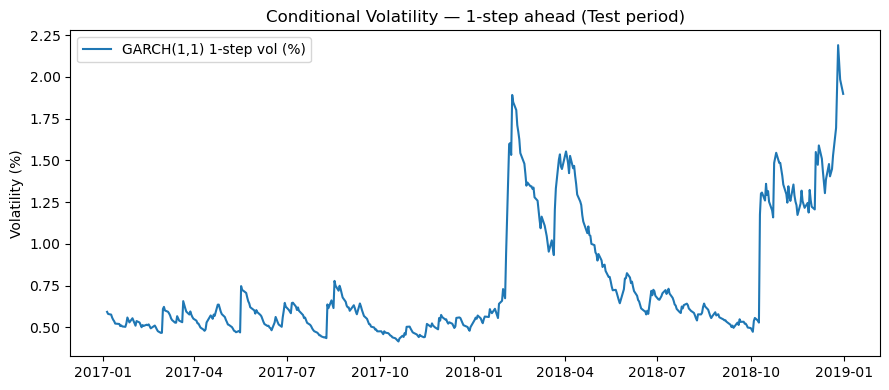

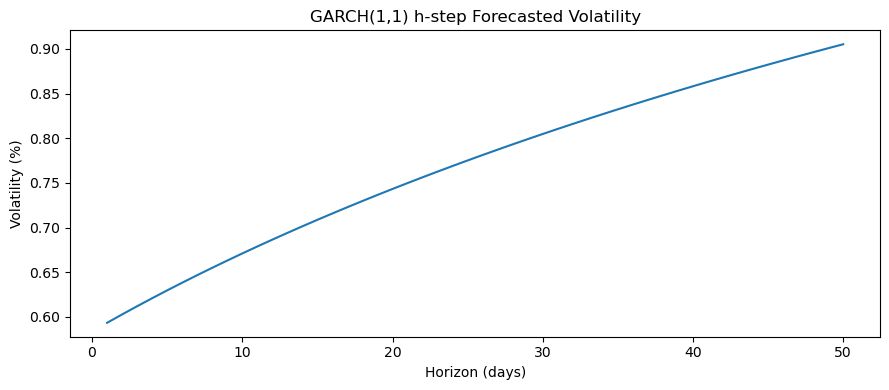

In [33]:
plt.figure(figsize=(9, 4))
plt.plot(r_test.index, vol_1step.values, label=vol_1step.name)
plt.title("Conditional Volatility ‚Äî 1-step ahead (Test period)")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(vol_h.index, vol_h.values)
plt.title("GARCH(1,1) h-step Forecasted Volatility")
plt.xlabel("Horizon (days)")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()